In [2]:
%pylab inline
import pyart
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


In [3]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    Asumes standard atmosphere, ie R=4Re/3
    """
    Re = 6371.0 * 1000.0
    #h=(r^2 + (4Re/3)^2 + 2r(4Re/3)sin(ele))^1/2 -4Re/3
    #s=4Re/3arcsin(rcos(ele)/(4Re/3+h))
    p_r = 4.0 * Re / 3.0
    rm = rng
    z = (rm ** 2 + p_r ** 2 + 2.0 * rm * p_r *
         np.sin(ele * np.pi / 180.0)) ** 0.5 - p_r
    #arc length
    s = p_r * np.arcsin(rm * np.cos(ele * np.pi / 180.) / (p_r + z))
    if debug:
        print "Z=", z, "s=", s
    y = s * np.cos(az * pi / 180.0)
    x = s * np.sin(az * pi / 180.0)
    return x, y, z, s

def grab_profile(radar,field,desrg,desz):
    rg,az=np.meshgrid(radar.range['data'][:],radar.azimuth['data'][:])
    rg,el=np.meshgrid(radar.range['data'][:],radar.elevation['data'][:])
    x,y,z,s=radar_coords_to_cart(rg,az,el)
    s=np.sqrt(x**2.+y**2.)
    #    f=interpolate.interp2d(s,z,radar.fields[field]['data'][:])

    #    znew=f(desrg,desz)
    sz=np.shape(s.ravel())
    points=np.zeros([sz[0],2])
    points[:,0]=s.ravel()
    points[:,1]=z.ravel()

    znew=interpolate.griddata(points, radar.fields[field]['data'][:].ravel(),
                          (desrg,desz), method='linear')
    return znew


radar={}
radar=pyart.aux_io.read_d3r_gcpex_nc("/Volumes/wdu/gpm/gcpex/d3r/rawnc-ku-cfoff/kud3r_20120218_103731_01.nc")

In [4]:
display={}
display = pyart.graph.RadarDisplay(radar)

(0, 40)

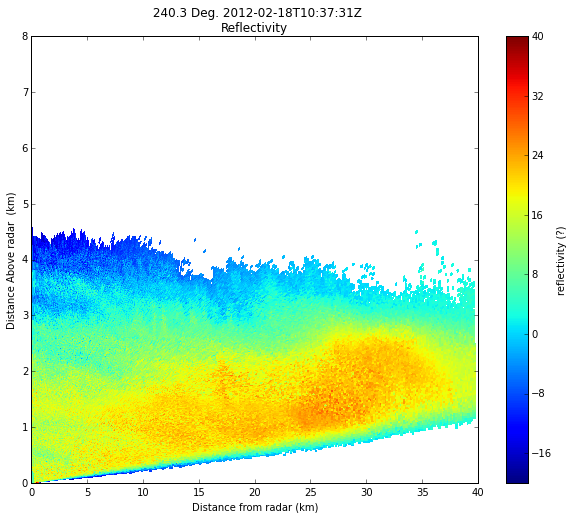

In [6]:
fig = plt.figure(figsize = [10,8])
display.plot_rhi('reflectivity',vmin=-20,vmax = 40,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

In [132]:
desrg=10000.+np.zeros([500])
desz=np.arange(0,10000.,20.)

fields=['reflectivity','differential reflectivity','correlation_coefficient','
out=grab_profile(radar,'reflectivity',10000.+np.zeros([10]),np.arange(0,10000.,1000.))

#plt.plot(dbz_out,np.arange(0,10,1),'.r')

In [133]:
znew

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  13.63823387,
        14.23736382,          nan,  13.3078158 ,  14.60540922,
        15.16421247,  14.77637486,  15.11147041,  14.40169718,
        14.73751879,          nan,  15.48231538,          nan,
        15.9817863 ,  15.41471057,          nan,  16.26392857,
        14.26731526,  14.28535275,          nan,          nan,
                nan,  14.80752094,  14.8295197 ,  14.7736312 ,
        14.99173634,  14.55740258,          nan,  15.43004199,
        16.52610577,  16.37419819,  16.18517498,  15.72627275,
        17.91870881,  16.51566586,  18.23802253,  15.88017404,
        17.45379746,  17.21216568,  17.72905113,  17.58743577,
        16.30608358,  18.57881511,  16.70028232,  17.58

(0, 4000)

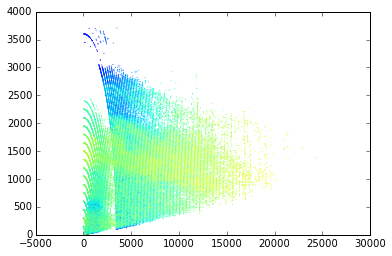

In [126]:
plt.scatter(s.ravel(),z.ravel(),1,radar.fields[field]['data'][:].ravel(),vmin=0,vmax=30,linewidths=0)
plt.scatter(desrg,desz,1,znew,1,vmin=0,vmax=30,linewidths=0)
plt.ylim([0,4000])

(0, 40)

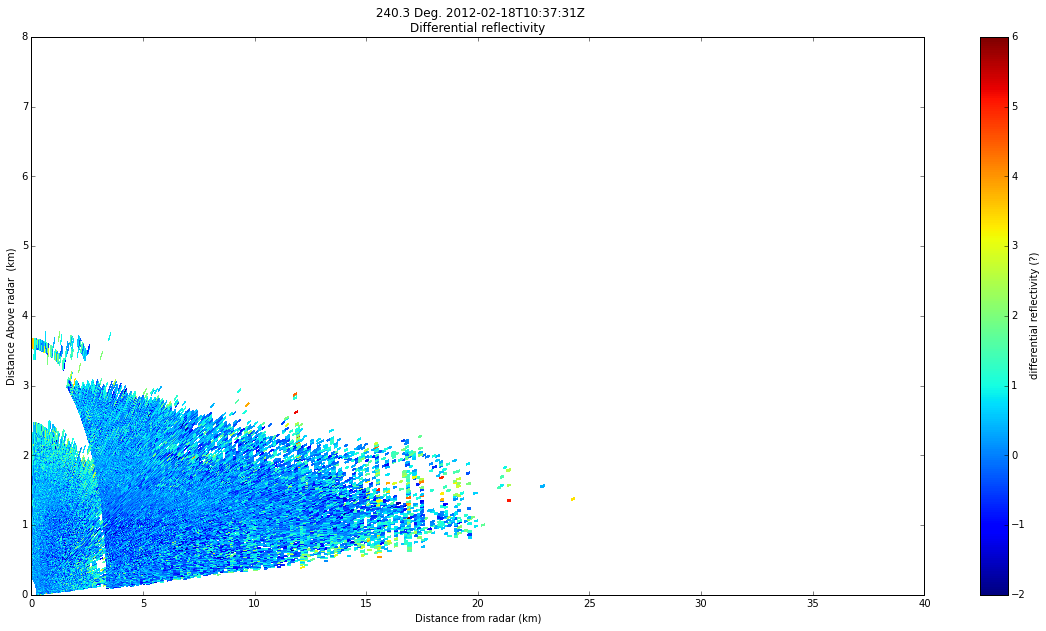

In [47]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('differential_reflectivity',vmin=-2,vmax = 6,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

(0, 40)

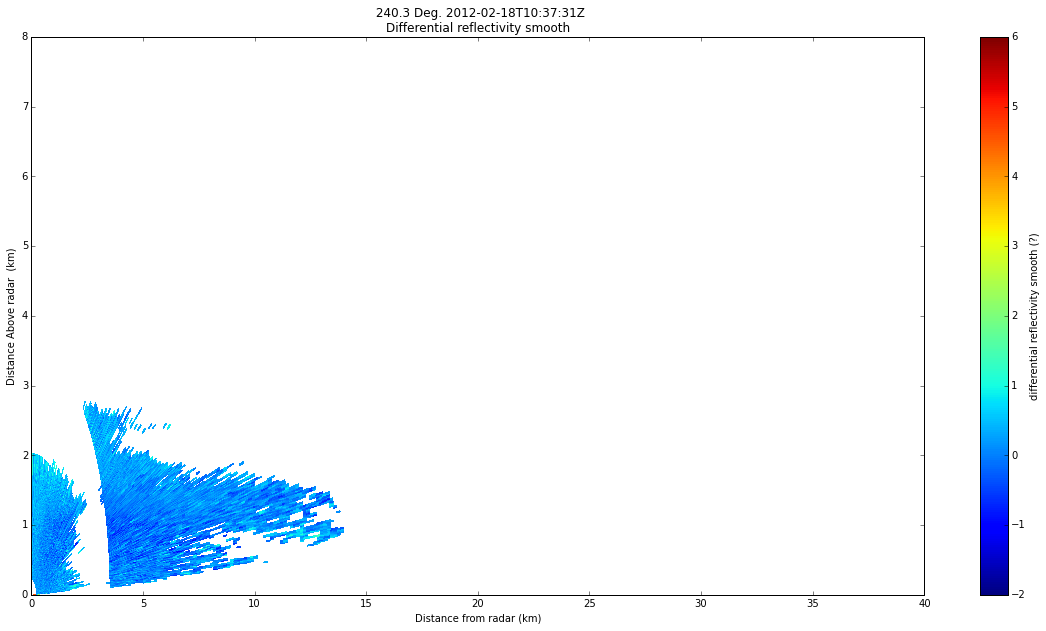

In [48]:
# First we create an independant copy of one of our radar fields.. we need to make sure changes made do not 
# infer back onto the object it was copied from (common cause of issues in Python)

smooth_zdr = radar.fields['differential_reflectivity']['data'].copy()

# Now for each of the radials in the volume we want to do an 8-point smooth by convolving the data with a Hanning window..
# rather than write out the code here we are going to use Py-ART's smooth and trim function which also makes sure
# the returned array has the same size as the original array.. 
# Check here: https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242
for i in range(smooth_zdr.shape[1]):
    smooth_zdr[:,i] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[:,i], 4)
for i in range(smooth_zdr.shape[0]):
    smooth_zdr[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_zdr[i,:], 4)

# Now that we have add this data as a new field, using the same metadata as the 
# differential_reflectivity field.

radar.add_field_like('differential_reflectivity', 'differential_reflectivity_smooth',  smooth_zdr)

fig = plt.figure(figsize = [20,10])
display.plot_rhi('differential_reflectivity_smooth',vmin=-2,vmax = 6,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

(0, 40)

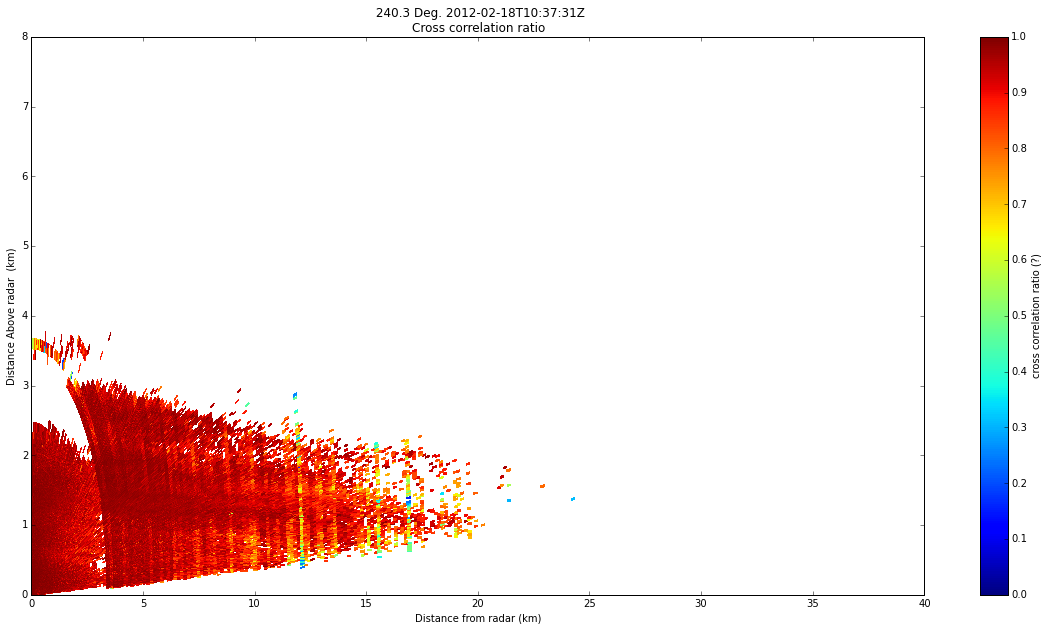

In [49]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('cross_correlation_ratio',vmin=0,vmax = 1,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

(0, 40)

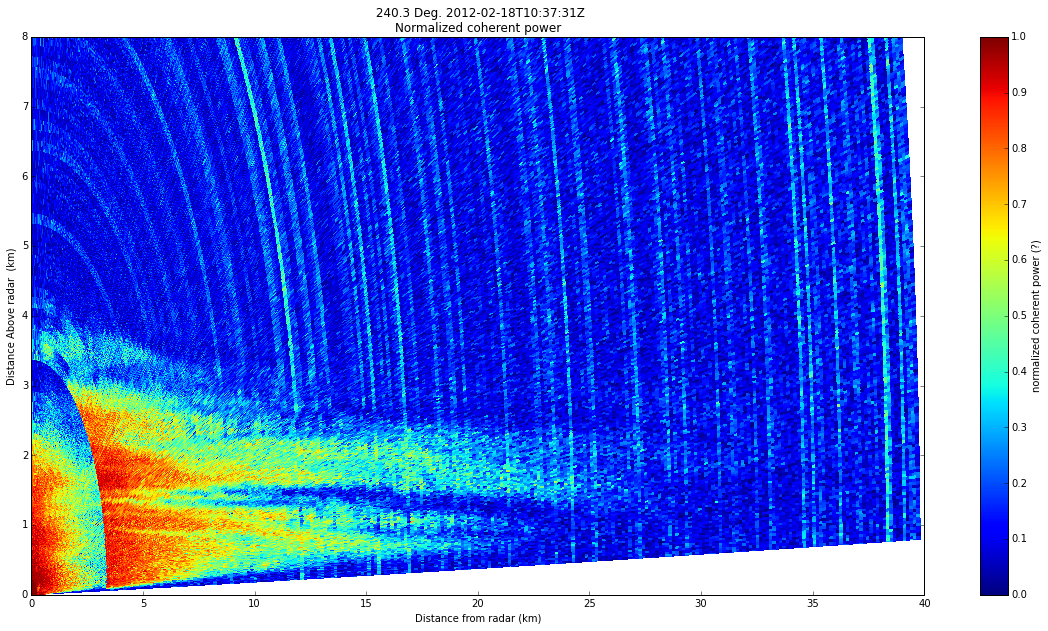

In [50]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('normalized_coherent_power',vmin=0,vmax = 1,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

(0, 40)

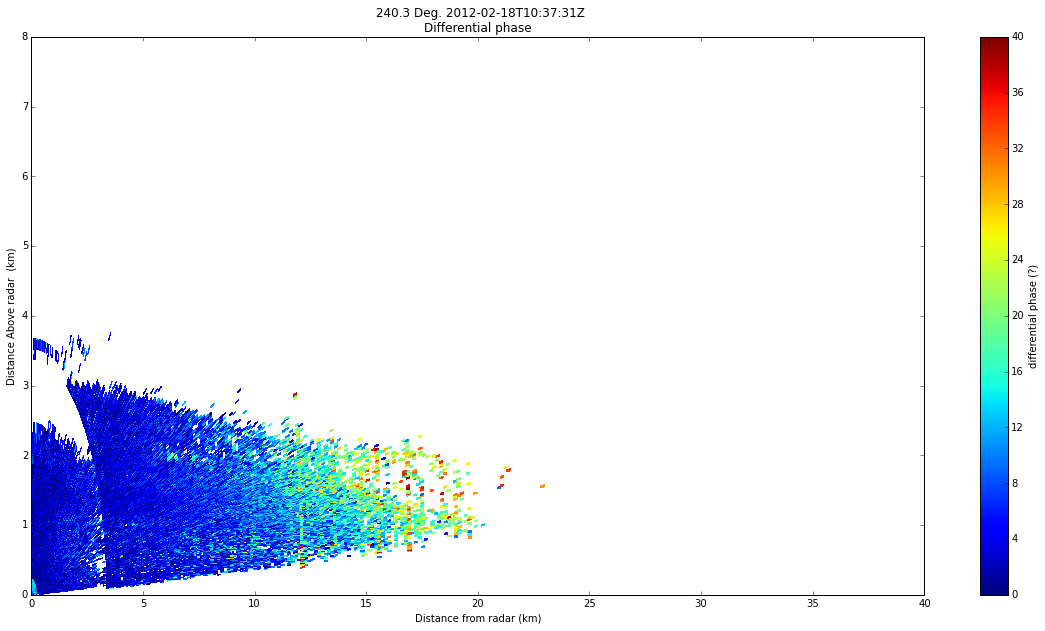

In [51]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('differential_phase',vmin=0,vmax = 40,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

In [5]:
# First we create an independant copy of one of our radar fields.. we need to make sure changes made do not 
# infer back onto the object it was copied from (common cause of issues in Python)

smooth_phi = radar.fields['differential_phase']['data'].copy()

# Now for each of the radials in the volume we want to do an 8-point smooth by convolving the data with a Hanning window..
# rather than write out the code here we are going to use Py-ART's smooth and trim function which also makes sure
# the returned array has the same size as the original array.. 
# Check here: https://github.com/ARM-DOE/pyart/blob/master/pyart/correct/phase_proc.py#L242
for i in range(smooth_phi.shape[1]):
    smooth_phi[:,i] = pyart.correct.phase_proc.smooth_and_trim(smooth_phi[:,i], 4)
for i in range(smooth_phi.shape[0]):
    smooth_phi[i,:] = pyart.correct.phase_proc.smooth_and_trim(smooth_phi[i,:], 4)

# Now that we have add this data as a new field, using the same metadata as the 
# differential_reflectivity field.

radar.add_field_like('differential_phase', 'differential_phase_smooth',  smooth_phi)

(0, 40)

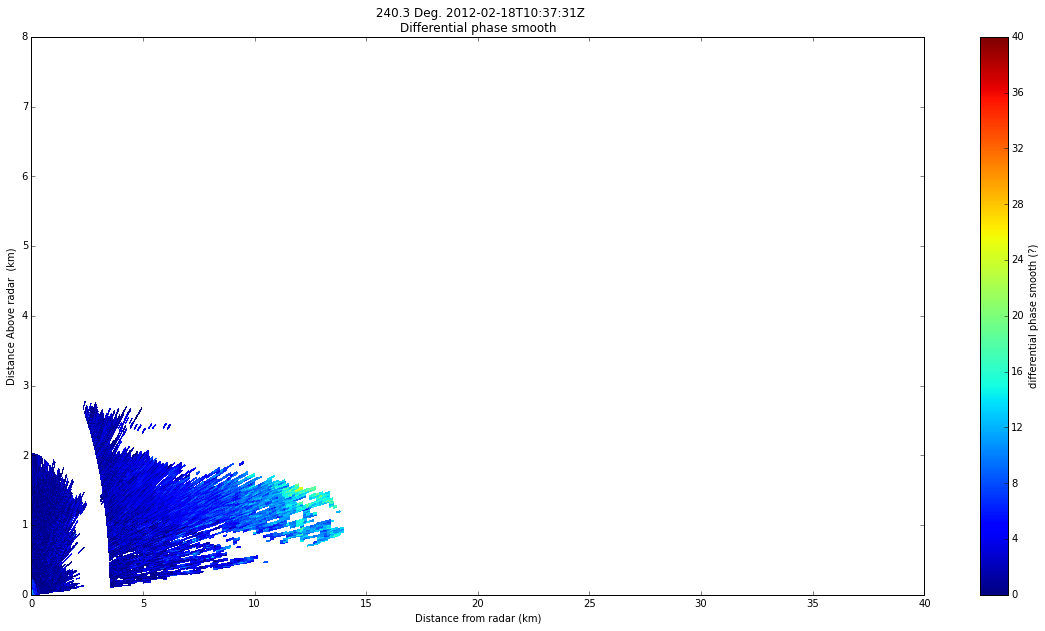

In [53]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('differential_phase_smooth',vmin=0,vmax = 40,sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

In [19]:
sz=np.shape(radar.fields['differential_phase']['data'])
for i in np.arange(0,sz[0]):
    radar.fields['differential_phase']['data'][i,0:25]=np.mean(radar.fields['differential_phase']['data'][i,25:50],axis=0)
    
phidp, kdp = pyart.correct.phase_proc_lp(radar, 0.0, refl_field='reflectivity',
                  ncp_field='normalized_coherent_power', min_ncp=0.3, min_rhv=0.6, rhv_field='cross_correlation_ratio',
                  phidp_field='differential_phase',
                  LP_solver='cylp',self_const=60000.,sys_phase=0.,overide_sys_phase=True)
radar.fields['proc_dp_phase_shift'] = phidp
radar.fields['recalculated_diff_phase'] = kdp
#radar.fields['recalculated_diff_phase']['data'][:]=\
#    np.ma.masked_where(radar.fields['cross_correlation_ratio']['data'][:] < 0.6,radar.fields['recalculated_diff_phase']['data'][:])


/Users/snesbitt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


(0, 40)

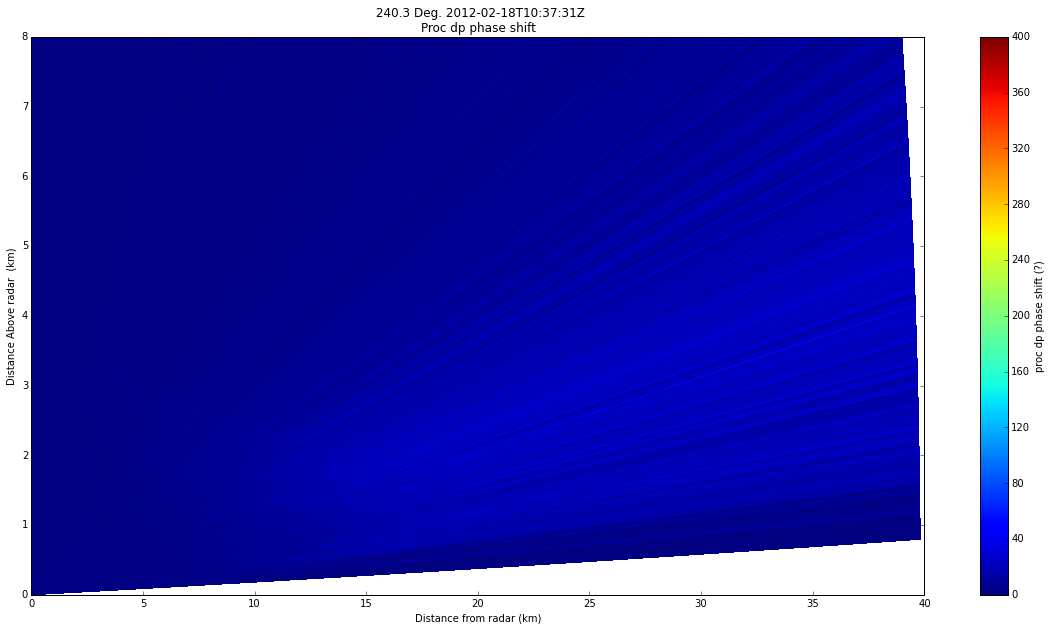

In [12]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('proc_dp_phase_shift',sweep=0)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

(0, 40)

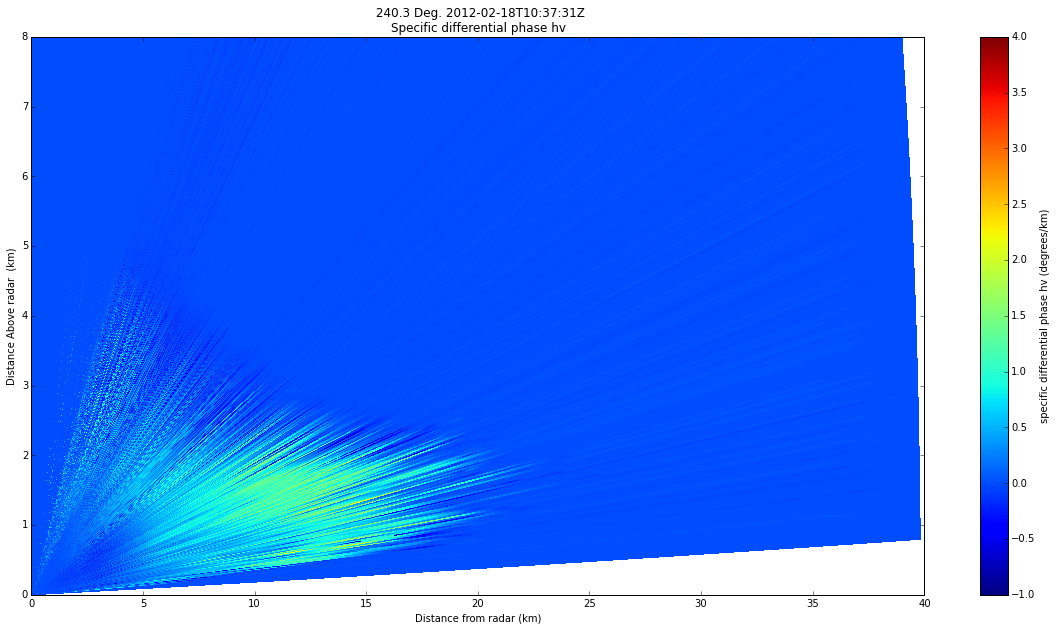

In [20]:
fig = plt.figure(figsize = [20,10])
display.plot_rhi('recalculated_diff_phase',sweep=0,vmin=-1,vmax=4)
plt.gca().set_ylim([0,8])
plt.gca().set_xlim([0,40])

In [14]:
rg,az=np.meshgrid(radar.range['data'][:],radar.azimuth['data'][:])
rg,el=np.meshgrid(radar.range['data'][:],radar.elevation['data'][:])


In [48]:
fixedang="%5.1f" % radar.fixed_angle['data'][:]
datestr=radar.time['units'][14:]
print fixedang.strip()
print radar.metadata['system']

240.3
KaD3R


In [55]:

desrg=10000.+np.zeros([500])
desz=np.arange(0,10000.,20.)

fixedang="%5.1f" % radar.fixed_angle['data'][:]
datestr=radar.time['units'][14:]


fields=['reflectivity','differential_reflectivity','cross_correlation_ratio','recalculated_diff_phase']

for fn in fields:
    out=grab_profile(radar,fn,10000.+np.zeros([100]),np.arange(0,10000.,100.))
    np.savetxt(radar.metadata['system']+'_'+datestr+'_'+fixedang.strip()+'_'+fn+'.txt', out)
#    f=open(radar.metadata['system']+'_'+datestr+'_'+fixedang.strip()+'_'+fn+'.txt','w')
#    f.write('%20s %10f\n' % (datestr, [datestr,np.char.mod("%5.2f", out)]))
#    f.close()
#plt.plot(dbz_out,np.arange(0,10,1),'.r')

In [43]:
np.shape(np.arange(0,10000.,25.))

(400,)

In [136]:
np.shape(kdp)

()

array([[ -6.38306514e-07,  -1.91491954e-06,  -3.19153257e-06, ...,
         -2.59439861e-12,  -7.53927784e-13,   0.00000000e+00],
       [ -6.38306514e-07,  -1.91491954e-06,  -3.19153257e-06, ...,
         -2.59439861e-12,  -7.53927784e-13,   0.00000000e+00],
       [ -6.38306514e-07,  -1.91491954e-06,  -3.19153257e-06, ...,
         -2.59439861e-12,  -7.53927784e-13,   0.00000000e+00],
       ..., 
       [  2.68542669e-05,   7.84887654e-05,   1.13104884e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.47483102e-05,   7.41179329e-05,   1.14636749e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.34777901e-05,   7.21032608e-05,   1.14706685e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [56]:
np.arange(0,10000.,20.)

array([    0.,    20.,    40.,    60.,    80.,   100.,   120.,   140.,
         160.,   180.,   200.,   220.,   240.,   260.,   280.,   300.,
         320.,   340.,   360.,   380.,   400.,   420.,   440.,   460.,
         480.,   500.,   520.,   540.,   560.,   580.,   600.,   620.,
         640.,   660.,   680.,   700.,   720.,   740.,   760.,   780.,
         800.,   820.,   840.,   860.,   880.,   900.,   920.,   940.,
         960.,   980.,  1000.,  1020.,  1040.,  1060.,  1080.,  1100.,
        1120.,  1140.,  1160.,  1180.,  1200.,  1220.,  1240.,  1260.,
        1280.,  1300.,  1320.,  1340.,  1360.,  1380.,  1400.,  1420.,
        1440.,  1460.,  1480.,  1500.,  1520.,  1540.,  1560.,  1580.,
        1600.,  1620.,  1640.,  1660.,  1680.,  1700.,  1720.,  1740.,
        1760.,  1780.,  1800.,  1820.,  1840.,  1860.,  1880.,  1900.,
        1920.,  1940.,  1960.,  1980.,  2000.,  2020.,  2040.,  2060.,
        2080.,  2100.,  2120.,  2140.,  2160.,  2180.,  2200.,  2220.,
      